In [241]:
import pandas as pd
from os.path import join
from os import listdir
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import time,timedelta,datetime as dt
from glob import glob

sns.set()
sns.set_context('talk')
%matplotlib inline

In [ ]:
home_dir = '/Users/ianbolliger/Dropbox/Temperature & Behavior/Experiments'

# Utility Funcs

In [413]:
def correct_raw_timing_df(timing_df,start_date,end_date):
    timing_df = timing_df.loc[start_date:end_date,:]

    # Drop cancelled sessions
    timing_df = timing_df[~((timing_df['Time entering room'].isin(["Cancelled",'canceled',''])) | (timing_df['Time entering room'].isnull()))]

    # Convert to datetime objects
    timing_df['start_time'] = pd.to_datetime(
        timing_df.index.get_level_values(0).astype(str) + 'T' + timing_df['Time entering room'])
    timing_df['end_time'] = pd.to_datetime(
        timing_df.index.get_level_values(0).astype(str) + 'T' + timing_df['Time ending modules'])

    # Impute end time from other concurrent session if not recorded
    min_end_times = timing_df.groupby(level=[0,1])['end_time'].min()
    max_start_times = timing_df.groupby(level=[0,1])['start_time'].max()
    imputed_vals = pd.DataFrame({'min_end_time':min_end_times,
                   'max_start_time':max_start_times},index = min_end_times.index)

    imputed_vals = imputed_vals.append(imputed_vals)
    imputed_vals['Treatment group'] = [0] * int(imputed_vals.shape[0] / 2) + [1] * int(imputed_vals.shape[0] / 2)
    imputed_vals = imputed_vals.set_index('Treatment group',append=True)

    timing_df = timing_df.join(imputed_vals)
    timing_df.loc[:,'start_time'] = timing_df.loc[:,'start_time'].where(
        cond=timing_df.loc[:,'start_time'].notnull(), other=timing_df['max_start_time'])
    timing_df.loc[:,'end_time'] = timing_df.loc[:,'end_time'].where(
        cond=timing_df.loc[:,'end_time'].notnull(), other=timing_df['min_end_time'])

    timing_df = timing_df[['start_time','end_time']]

    ## Correct for not using 24 hour clock
    for i in ['start_time','end_time']:
        bad_times_bool = (timing_df[i].dt.time < time(8))
        bad_times = timing_df.loc[bad_times_bool,i]
        new_times = bad_times + timedelta(hours=12)
        timing_df[i] = timing_df[i].where(bad_times_bool==False,other=new_times)
    
    # Turn session number into integer
    timing_df.index = timing_df.index.set_levels([1,2], 1)
    
    return timing_df


def make_full_plots(dfs,timing_df,out_name,site_str='Berkeley',dfs_od=None):
    
    if site_str == 'Berkeley':
        positions = ('partition','RA')
        positions_pretty = ('Behind Partition','Under RA Desk')
    elif site_str == 'Busara':
        positions = ('near','far')
        positions_pretty = ('Near','Far')
        
    experiment_dates = timing_df.index.get_level_values(0).unique()
    n_ex = len(experiment_dates)

    pretty_metrics = ['Temperature','RH']
    marker_colors = ['b','g']
    
    for mi,metric in enumerate(['T','RH']):

        fig,ax = plt.subplots(n_ex,2,figsize = (12,n_ex*6))
        if len(experiment_dates) == 1: ax = np.array([ax])
        
        for ei,e in enumerate(experiment_dates):
            if e < pd.to_datetime(sensor_swap_date):
                interval = sensor_interval_early
            else:
                interval = sensor_interval
                
                
            # load min, mean, max outside temps for that day
            if dfs_od:
                od_data = {'min':dfs_od['min'][e.date()],
                          'mean':dfs_od['mean'][e.date()],
                          'max':dfs_od['max'][e.date()]}
            
            for gi,g in enumerate(['control','treatment']):
                
                this_ax = ax[ei,gi]
                first_ax = ax[0,0]
                second_ax = ax[0,1]
                last_ax = ax[n_ex-1,1]
                    
                for sesh in [1,2]:
                    
                    # skip if session was cancelled
                    this_group = (e,sesh,gi)
                    if this_group not in timing_df.index:
                        continue
                    times = timing_df.loc[this_group]

                    # produce values for behind partition and under RA desk
                    metric_df = dfs[g][positions[0]].loc[times['start_time']:times['end_time'],metric]
                    metric_df = metric_df.reset_index(drop=True)
                    metric_df.index = metric_df.index*interval
                    metric_df.name = '{} {}, Session {}'.format(pretty_metrics[mi],positions_pretty[0],sesh)
                    metric_df.plot(ax=this_ax,color=marker_colors[int(sesh)-1])

                    metric_df = dfs[g][positions[1]].loc[times['start_time']:times['end_time'],metric]
                    metric_df = metric_df.reset_index(drop=True)
                    metric_df.index = metric_df.index*interval
                    metric_df.name = '{} {}, Session {}'.format(pretty_metrics[mi],positions_pretty[1],sesh)
                    metric_df.plot(ax=this_ax,style=':',color=marker_colors[int(sesh)-1])
                    
                    if dfs_od:
                        xlim = this_ax.get_xlim()
                        for i in [('r','min'),('b','mean'),('r','max')]:
                            this_ax.plot(xlim,[od_data[i[1]]],i[0])
                        
                this_ax.set_title('{}, {}'.format(e.date(), g.title()))
        
        last_ax.legend(loc='lower right')
        last_ax.set_xlabel('Minutes')
        ax[-1,0].set_xlabel('Minutes')
        
        # share axes down columns
        for i in [0,1]:
            axes_ylims = [ax[j,i].get_ylim() for j in range(n_ex)]
            min_y = min([j[0] for j in axes_ylims])
            max_y = max([j[1] for j in axes_ylims])
            [ax[j,i].set_ylim((min_y,max_y)) for j in range(n_ex)]
        ax[0,0].get_shared_y_axes().join(*list(ax[:,0]))
        ax[0,1].get_shared_y_axes().join(*list(ax[:,1]))
        
        fig.suptitle('{} {} Measurements'.format(
            site_str.title(),pretty_metrics[mi]),fontsize=18)
        fig.tight_layout()
        fig.subplots_adjust(top=.95)
        fig.savefig('../../results/figures/main_experiment/{}_{}_{}.png'.format(out_name,site_str,metric))

    return None

# Berkeley

In [316]:
timing_dir = '../../data/raw/RA_records'

temps_dir_berk = join(home_dir,'Xlab data','Main experiment data','Temperature')

start_date = '2017-09-25'
full_fig_start_date = '2017-10-30'
end_date = '2017-11-03'

sensor_swap_date = '2017-10-03'
sensor_interval_early = 5
sensor_interval = 1

out_name = 'temps_detail_{}'.format(end_date)
download_dates = [dt.strptime(i,'%Y%m%d') for i in listdir(join(temps_dir_berk,'indoor')) if i[0] != '.']
download_dates.sort()

## Get session timing data

In [375]:
# Load csv containing start and stop times for session
raw_timing_df_berk = pd.read_csv(join(timing_dir,'timing_berkeley.csv'),index_col = [0,1,2], parse_dates = True,
            usecols=['Date','Session in day','Treatment group','Time entering room','Time ending modules'])

timing_df = correct_raw_timing_df(raw_timing_df_berk,start_date,end_date)

## Get outdoor temp/RH data

In [161]:
def get_outdoor_data(temp_dir):
    files_od = glob(join(temp_dir,'20*.xlsx'))
    df_od = pd.DataFrame()

    for f in files_od:
        this_df = pd.read_excel(f,sheet_name='DATA',usecols='B:D',index_col=0,parse_dates=True)
        this_df.columns = ['T','RH']
        this_df.index.name = 'time'

        # convert to celsius
        this_df['T'] = (this_df['T'] - 32) * 5/9
        df_od = df_od.append(this_df)

    df_od = df_od[~df_od.index.duplicated(keep='last')].sort_index()
    
    # remove first and last day to ignore days where we did not get full recording
    df_od = df_od.iloc[1:-1,:]
    
    # separate out into daily min,mean,max
    groups = df_od.groupby(df_od.index.date)
    dfs_od = {'all':df_od,
             'min': groups.min(),
             'mean': groups.mean(),
             'max': groups.max()}
    
    for i in ['min','mean','max']:
        # remove first and last day to ignore days where we did not get full recording
        dfs_od[i] = dfs_od[i].iloc[1:-1,:]
    
    
    return dfs_od

In [162]:
dfs_od = get_outdoor_data(join(temps_dir_berk,'Outdoor'))

## Get temp/RH data from sessions

In [30]:
def load_vals_berkeley(download_dates):
    """Input all temperature data from Berkeley experiment into dataframe."""
    
    dfs = {'treatment':{},
          'control':{},
          'outdoor':{}}

    # grab room temp data from both control and treatment rooms
    for gi,g in enumerate(['control','treatment']):
        
        ## download data from early in experiment when we were using different sensors
        dfs[g]['partition'] = pd.read_excel(join(temps_dir_berk,'indoor',download_dates[0].strftime('%Y%m%d'),'{}_p.xls'.format(g)),
                          sheet_name='Records',parse_dates=True,index_col=0).loc[:pd.to_datetime(sensor_swap_date),:]
        
        dfs[g]['RA'] = pd.read_excel(join(temps_dir_berk,'indoor',download_dates[0].strftime('%Y%m%d'),'{}_RA.xls'.format(g)),
                          sheet_name='Data Table',parse_dates=True,index_col=1,header=21).iloc[:,1].loc[:pd.to_datetime(sensor_swap_date)]
        dfs[g]['RA'].name = 'T'
        dfs[g]['RA'] = pd.DataFrame(dfs[g]['RA'])
        dfs[g]['RA']['RH'] = np.nan
        
        for loc in ['partition','RA']:  
            dfs[g][loc].columns = ['T','RH']
            dfs[g][loc].index.name='time'
        
        ## now download data from sensors we switched to
        for d in download_dates[1:]:
            for loc in [('partition','p'),('RA','RA')]:
                new_df = pd.read_csv(join(temps_dir_berk,'indoor',d.strftime('%Y%m%d'),'csvs',
                        '{}_{}.csv'.format(g,loc[1])),usecols=[1,2,3],header=1,
                       index_col=0,parse_dates=True).loc[pd.to_datetime(sensor_swap_date):,:]
                new_df.columns=['T','RH']
                new_df.index.name='time'
                dfs[g][loc[0]] = dfs[g][loc[0]].append(new_df)
            
        for loc in ['partition','RA']:  
            dfs[g][loc] = dfs[g][loc][~dfs[g][loc].index.duplicated(keep='last')].sort_index()
            
    return dfs

In [57]:
dfs = load_vals_berkeley(download_dates)

## Make Plots

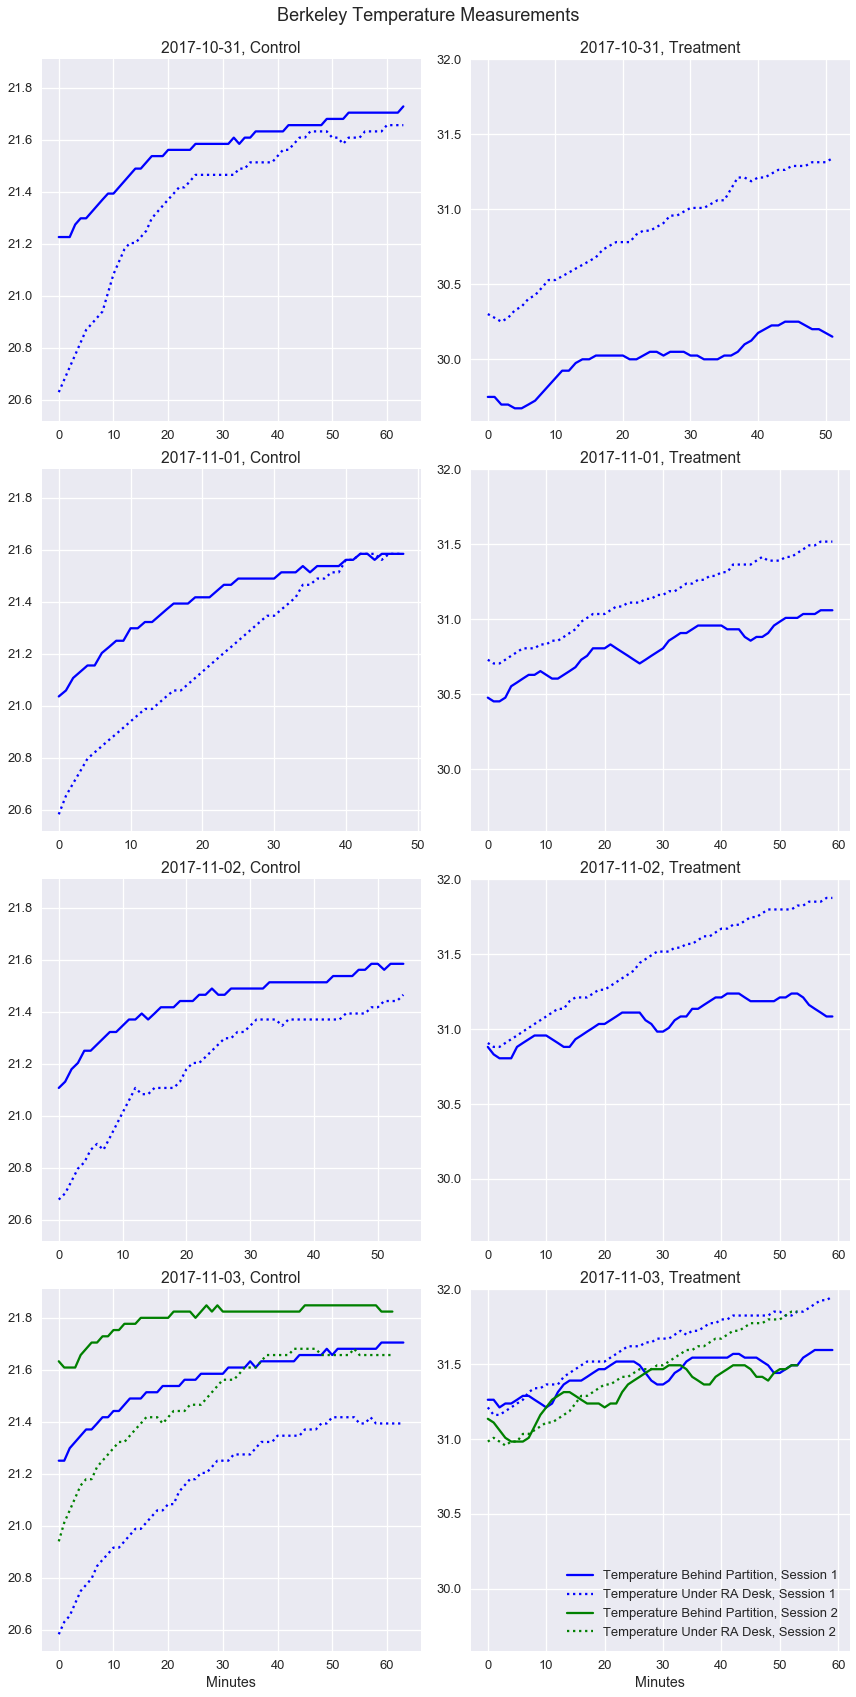

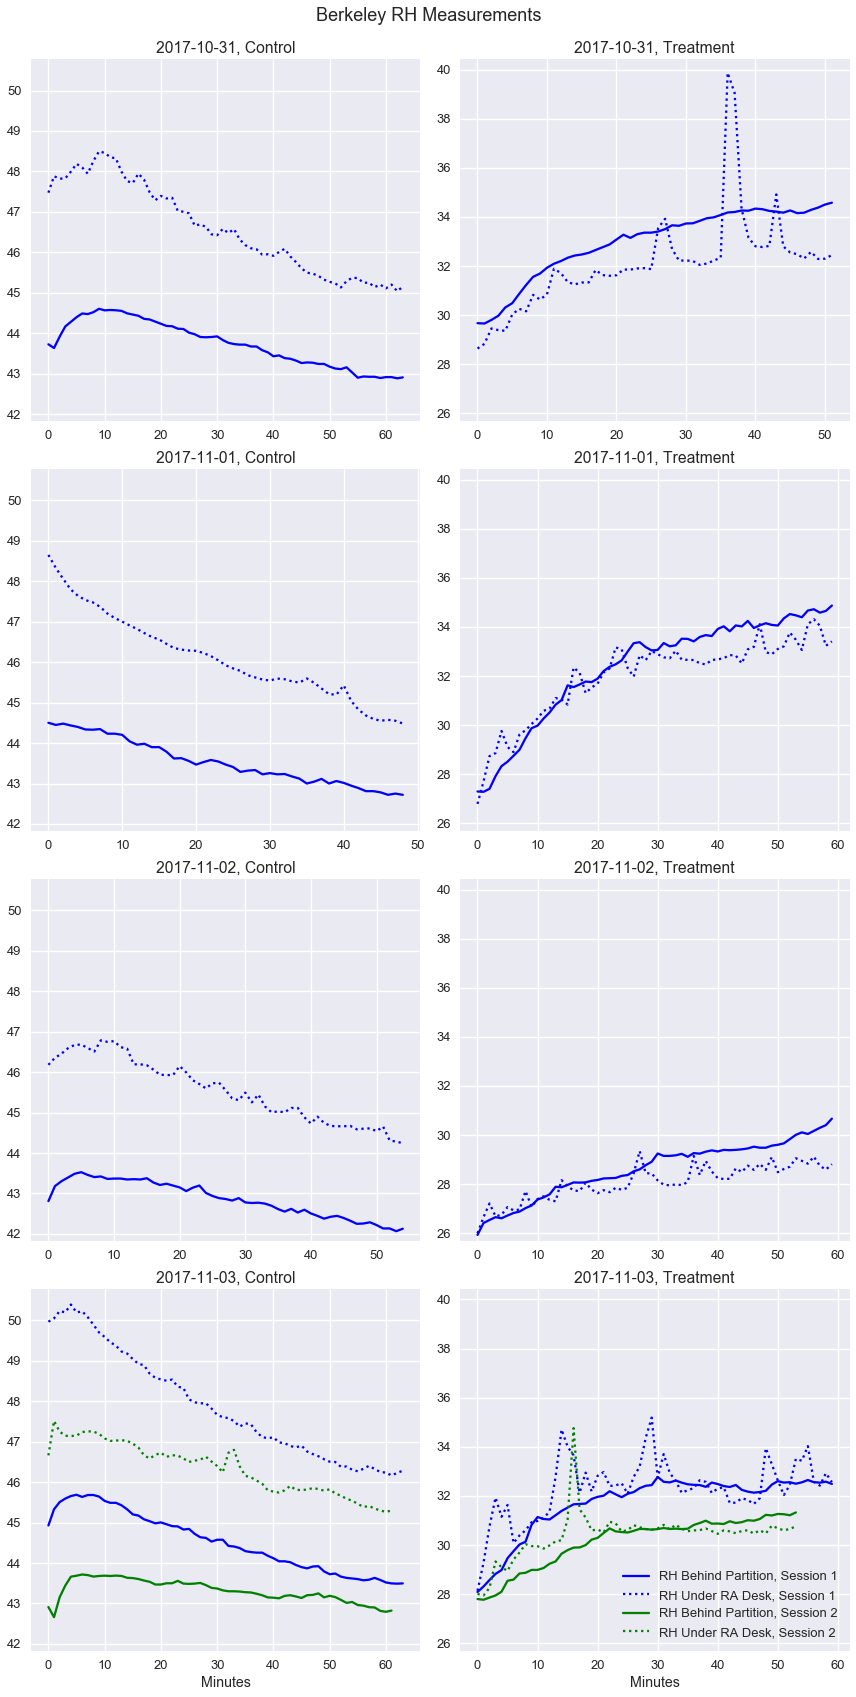

In [386]:
# make full plots
idx = pd.IndexSlice
full_fig_timing = timing_df.loc[idx[full_fig_start_date:end_date,:,:],:]
x = make_full_plots(dfs,full_fig_timing,out_name)

In [142]:
def get_session_level_data(dfs,timing_df,dfs_od):
    experiment_dates = timing_df.index.get_level_values(0).unique()
    n_ex = len(experiment_dates)

    pretty_metrics = ['Temperature','RH']
    marker_colors = ['b','g']
    
    means_id = {}
    od_data = {}
    for i in ['T','RH']:
        od_data[i] = {}
        for j in ['min','mean','max']:
            od_data[i][j] = []
            
    for gi,g in enumerate(['control','treatment']):
        
        means_id[g] = {}
        
        for m in ['T','RH']:
            means_id[g][m]={}
            for area in ['partition','RA']:
                means_id[g][m][area] = []
            
        for e in experiment_dates:
            for s in ['1','2']:

                # skip if session was cancelled
                this_group = (e,s,gi)
                if this_group not in timing_df.index:
                    continue
                times = timing_df.loc[this_group]

                # calc_means for behind partition and under RA desk
                for area in ['partition','RA']:
                    metric_df = dfs[g][area].loc[times['start_time']:times['end_time'],:]
                    this_means = metric_df.mean()
                    for m in ['T','RH']:
                        means_id[g][m][area].append(this_means[m])
                        
                # get outdoor mean (only need to do once)
                if gi == 0:
                    for i in ['min','mean','max']:
                        for m in ['T','RH']:
                            try:
                                this_data = dfs_od[i].loc[e.date(),m]
                            except:
                                this_data = np.nan
                            od_data[m][i].append(this_data)
            
    return means_id,od_data

In [209]:
def plot_means(means,means_this_week,od_data):
    
    fig,ax = plt.subplots(1,2,figsize = (12,6))

    for ix,i in enumerate(['control','treatment']):
        mean_temps = pd.DataFrame(means[i]['T'])
        mean_temps.plot(ax=ax[ix])
        ax[ix].set_title('Mean temps per experiment, {}'.format(i.title()))
        ax[ix].legend(loc='upper right')
        lns1 = ax[ix].get_lines()
        
        ax2 = ax[ix].twinx()
        ax2.grid(False,which='both')
        od_mean_temps = pd.Series(od_data['T']['mean'],name='Mean Daily T')
        with sns.axes_style('dark'):
            od_mean_temps.plot(ax=ax2,color='r')
        lns2 = ax2.get_lines()
        
        lns = lns1 + lns2
        ax[ix].set_ylabel('Room Temps, C')
        ax2.set_ylabel('Mean Daily Outdoor T, C')
        ax[ix].set_xlabel('Experiment #')
        labs = [l.get_label() for l in lns]
        ax[ix].legend(lns, labs, loc=0)
        
    ## mean of means for control
    control_means = means['control']['T']
    control_means_this_week = means_this_week['control']['T']
    mean_of_means_control = np.nanmean(np.array(control_means['RA'] + control_means['partition']))
    last_wk_mean_of_means_control = np.nanmean(np.array(
        control_means_this_week['RA'] + control_means_this_week['partition']))
    
    ## do mean of means for treatment using only partition sensor, since clear bias
    tx_means = means['treatment']['T']['RA']
    tx_means_this_week = means_this_week['treatment']['T']['RA']
    mean_of_means_tx = np.nanmean(np.array(tx_means))
    last_wk_mean_of_means_tx = np.nanmean(np.array(tx_means_this_week))

    ax[0].text(x = .5,y=.15,s='Mean of means (overall): {:.2f}'.format(mean_of_means_control),
               fontsize=14,transform = ax[0].transAxes,horizontalalignment='center')
    ax[0].text(x = .5,y=.05,s='Mean of means (last wk): {:.2f}'.format(last_wk_mean_of_means_control),
               fontsize=14,transform = ax[0].transAxes,horizontalalignment='center')
    ax[1].text(x = .5,y=.15,s='Mean of means (RA sensor only, overall): {:.2f}'.format(mean_of_means_tx),
               fontsize=14,transform = ax[1].transAxes,horizontalalignment='center')
    ax[1].text(x = .5,y=.05,s='Mean of means (RA sensor only, last wk): {:.2f}'.format(last_wk_mean_of_means_tx),
               fontsize=14,transform = ax[1].transAxes,horizontalalignment='center')

    fig.savefig('../../results/figures/main_experiment/{}_means.png'.format(out_name))
    
    return None

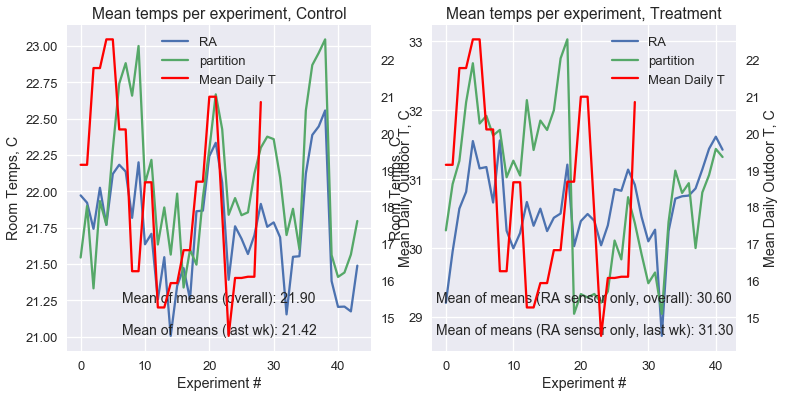

In [210]:
## get means over full experiment
means,od_data = get_session_level_data(dfs,timing_df,dfs_od)

# # ## get means over this week
means_this_week,od_data_this_week = get_session_level_data(dfs,full_fig_timing,dfs_od)

# # ## Plot
plot_means(means,means_this_week,od_data)

# Busara

In [410]:
main_dir_bus = join(home_dir,'Busara data','Main experiment data')
temps_dir_bus = join(main_dir_bus,'Temperature')
timing_fpath_bus = join(main_dir_bus,'timing_busara.csv')

start_date_bus_str = '20171019'
full_fig_start_date_bus_str = '20171019'
temps_detail_fig_prefix = 'temps_detail'

start_date_bus = dt.strptime(start_date_bus_str,'%Y%m%d')
full_fig_start_date_bus = dt.strptime(full_fig_start_date_bus_str,'%Y%m%d')

experiment_dates = [i[:-5] for i in listdir(join(temps_dir_bus,'indoor')) if i[0] != '.' and i[-4:]=='Warm']
experiment_dates.sort()
experiment_dates = [dt.strptime(i,'%Y%m%d') for i in experiment_dates 
                    if dt.strptime(i,'%Y%m%d') >= start_date_bus]
end_date_bus = experiment_dates[-1]

temps_detail_fig_name = '{}_{}'.format(temps_detail_fig_prefix,end_date_bus.strftime('%Y%m%d'))

## Get timing data

In [411]:
raw_timing_df_bus = pd.read_csv(timing_fpath_bus,index_col=[0,1,2],parse_dates=True)
timing_df_bus = correct_raw_timing_df(raw_timing_df_bus,start_date_bus,end_date_bus)

## Get Outdoor Temp/RH Data

In [279]:
def get_outdoor_data_bus(temp_dir):
    files_od = glob(join(temp_dir,'Busara*.csv'))
    df_od = pd.DataFrame()

    for f in files_od:
        this_df = pd.read_csv(f,usecols=[0,1,2],index_col=0,parse_dates=True,header=1)
        this_df.columns = ['T','RH']
        this_df.index.name = 'time'
        
        # Get rid of logging flags
        this_df = this_df[this_df.iloc[:,0] != ' ']
        this_df = this_df.astype(float)

        # convert to celsius
        this_df['T'] = (this_df['T'] - 32) * 5/9
        df_od = df_od.append(this_df)

    df_od = df_od[~df_od.index.duplicated(keep='last')].sort_index()
    
    # remove first and last day to ignore days where we did not get full recording
    df_od = df_od.iloc[1:-1,:]
    
    # separate out into daily min,mean,max
    groups = df_od.groupby(df_od.index.date)
    dfs_od = {'all':df_od,
             'min': groups.min(),
             'mean': groups.mean(),
             'max': groups.max()}
    
    for i in ['min','mean','max']:
        # remove first and last day to ignore days where we did not get full recording
        dfs_od[i] = dfs_od[i].iloc[1:-1,:]
    
    
    return dfs_od

In [280]:
dfs_od_bus = get_outdoor_data_bus(join(temps_dir_bus,'outdoor'))

## Get temp/RH data from sessions

In [308]:
def load_vals_bus(download_dates):
    """Input all temperature data from Berkeley experiment into dataframe."""
    
    dfs = {'treatment':{},
          'control':{},
          'outdoor':{}}

    # grab room temp data from both control and treatment rooms
    for gi,gx in enumerate([('Cool','control'),('Warm','treatment')]):
        
        ga = gx[0]
        g = gx[1]
        tx_lab = ga[0].upper()
        
        ## now download data from sensors we switched to
        for dx,d in enumerate(download_dates):
            d_str = d.strftime('%Y%m%d')
            for loc in [('far','F'),('near','N')]:
                try:
                    new_df = pd.read_csv(join(temps_dir_bus,'indoor','{}_{}'.format(d_str,ga),
                        '{}_Temp_{}{}.csv'.format(d_str,tx_lab,loc[1])),usecols=[1,2,3],header=1,
                       index_col=0,parse_dates=True).loc[pd.to_datetime(sensor_swap_date):,:]
                except:
                    new_df = pd.read_csv(join(temps_dir_bus,'indoor','{}_{}'.format(d_str,ga),
                        '{}_Temp_{}{}..csv'.format(d_str,tx_lab,loc[1])),usecols=[1,2,3],header=1,
                       index_col=0,parse_dates=True).loc[pd.to_datetime(sensor_swap_date):,:]
                new_df.columns=['T','RH']
                new_df.index.name='time'
                if dx == 0:
                    dfs[g][loc[0]] = new_df
                else:
                    dfs[g][loc[0]] = dfs[g][loc[0]].append(new_df)
            
        for loc in ['far','near']:  
            # drop duplicate times from multiple files
            dfs[g][loc] = dfs[g][loc][~dfs[g][loc].index.duplicated(keep='last')].sort_index()
            
            # drop data logger flag rows
            dfs[g][loc] = dfs[g][loc][dfs[g][loc].notnull().all(axis=1)]
        
    return dfs

In [412]:
dfs_id_bus = load_vals_bus(experiment_dates)

## Make Plots

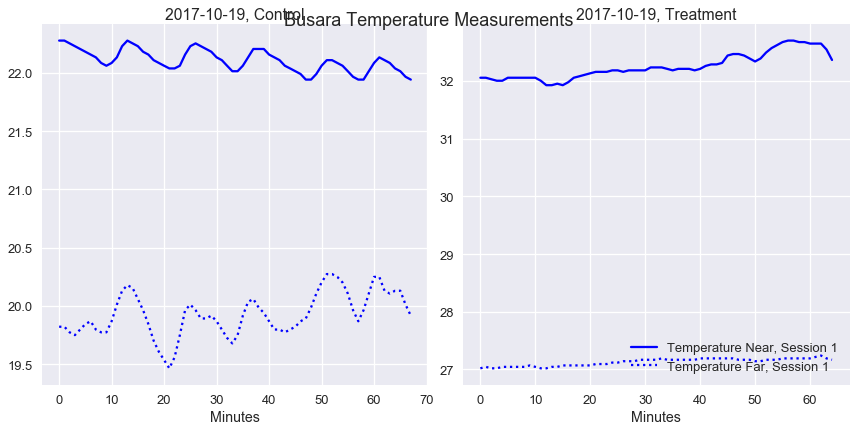

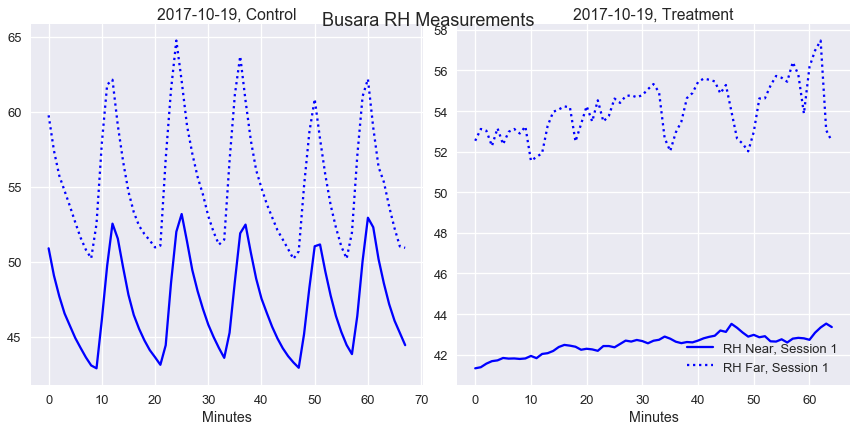

In [414]:
# make full plots
idx = pd.IndexSlice
full_fig_timing_bus = timing_df_bus.loc[idx[full_fig_start_date_bus:end_date_bus,:,:],:]
x = make_full_plots(dfs_id_bus,full_fig_timing_bus,temps_detail_fig_name,site_str='Busara')